In [1]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def cargar_depurar_datos(archivo):
    """
    Carga y depura un archivo CSV de precios de Bitcoin mensual,
    devolviendo tanto el DataFrame limpio como una estructura
    tipo lista de diccionarios de diccionarios.
    """
    
    df = pd.read_csv(archivo, skiprows=2)

    
    df = df.rename(columns={
        "Date": "Date",
        "Unnamed: 1": "Close",
        "Unnamed: 2": "High",
        "Unnamed: 3": "Low",
        "Unnamed: 4": "Open",
        "Unnamed: 5": "Volume"
    })

    
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    
    for col in ["Close", "High", "Low", "Open", "Volume"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

   
    df.dropna(inplace=True)

   
    df.set_index("Date", inplace=True)

    return df
archivo = "C:/Users/jeron/OneDrive/Escritorio/CoinPredictor/Datos/bitcoin_diario.csv"
df = cargar_depurar_datos(archivo)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4029 entries, 2014-09-17 to 2025-09-27
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4029 non-null   float64
 1   High    4029 non-null   float64
 2   Low     4029 non-null   float64
 3   Open    4029 non-null   float64
 4   Volume  4029 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 188.9 KB
None


In [3]:
set_entrenamiento = df.loc[:"2023-12-31"].iloc[:,1:2]
set_validacion = df.loc["2024-01-01":].iloc[:,1:2]

set_entrenamiento.info()
set_validacion.info()

set_entrenamiento.tail()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3393 entries, 2014-09-17 to 2023-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    3393 non-null   float64
dtypes: float64(1)
memory usage: 53.0 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 636 entries, 2024-01-01 to 2025-09-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    636 non-null    float64
dtypes: float64(1)
memory usage: 9.9 KB


,High
Date,
2023-12-27,43683.160156
2023-12-28,43804.781250
2023-12-29,43124.324219
2023-12-30,42584.125000
2023-12-31,42860.937500


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))


set_entrenamiento_escalado = scaler.fit_transform(set_entrenamiento)

print(set_entrenamiento_escalado)

[[0.00373944]
 [0.00357446]
 [0.00315122]
 ...
 [0.62574965]
 [0.61787249]
 [0.62190896]]


In [20]:
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)


for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [24]:
#Reshapear los datos par aingresarlos al modelo vector de 60×1
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [7]:
#Construir el modelo

from keras.models import Sequential
from keras.layers import LSTM, Dense

dim_entrada = (X_train.shape[1],1)
dim_salida = 1
neuronas = 150

modelo = Sequential()


#Capa 1 inicial - entrada
modelo.add(LSTM(units=neuronas, input_shape=dim_entrada))

#Capa salida
modelo.add(Dense(units=dim_salida))


print('Comenzando el entrenamiento...')
modelo.compile(optimizer='rmsprop', loss='mse')

modelo.fit(X_train,Y_train,epochs=50,batch_size=32)

print('Entrenamiento completado exitosamente')

c:\Users\jeron\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Comenzando el entrenamiento...
Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0022
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 7.6083e-04
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.1221e-04
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.8725e-04
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.0303e-04
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.5740e-04
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.6106e-04
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.2984e-04
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3.2706e-04
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.8415e-04
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.9178e-04
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.6285e-04
Epoch 13/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.4541e-04
Epoch 14/50
105/105 ━━━━━━━━━━━━━

In [25]:
#test y predicicones
x_test = set_validacion.values
x_test_scaled = scaler.transform(x_test)

X_test = []
for i in range(time_step,len(x_test_scaled)):
    X_test.append(x_test_scaled[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = scaler.inverse_transform(prediccion)

print(prediccion)


 6/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

c:\Users\jeron\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[ 65172.34 ]
 [ 65849.27 ]
 [ 65441.867]
 [ 65420.688]
 [ 68456.9  ]
 [ 70319.14 ]
 [ 70169.555]
 [ 70109.664]
 [ 71172.42 ]
 [ 70775.6  ]
 [ 71268.836]
 [ 73195.6  ]
 [ 74138.73 ]
 [ 75016.164]
 [ 75427.04 ]
 [ 74680.69 ]
 [ 72787.67 ]
 [ 71022.62 ]
 [ 70174.36 ]
 [ 69362.6  ]
 [ 69063.7  ]
 [ 69082.21 ]
 [ 68239.32 ]
 [ 67476.34 ]
 [ 68158.266]
 [ 70757.95 ]
 [ 72392.51 ]
 [ 73292.336]
 [ 73526.125]
 [ 73130.61 ]
 [ 72475.24 ]
 [ 72687.03 ]
 [ 72759.5  ]
 [ 71790.48 ]
 [ 69571.71 ]
 [ 69873.27 ]
 [ 69800.04 ]
 [ 70386.59 ]
 [ 71149.54 ]
 [ 73043.414]
 [ 73430.03 ]
 [ 73149.24 ]
 [ 73012.695]
 [ 72867.11 ]
 [ 70763.26 ]
 [ 68361.31 ]
 [ 67806.43 ]
 [ 66135.26 ]
 [ 65473.168]
 [ 65071.72 ]
 [ 65833.52 ]
 [ 66334.6  ]
 [ 66826.44 ]
 [ 68018.96 ]
 [ 68613.3  ]
 [ 68791.25 ]
 [ 67719.51 ]
 [ 66797.63 ]
 [ 65765.984]
 [ 65515.613]
 [ 65364.254]
 [ 65668.85 ]
 [ 63497.24 ]
 [ 61659.844]
 [ 63051.406]
 [ 64650.52 ]
 [ 65622.42 ]
 [ 66644.62 ]
 [ 66446

In [9]:
prediccion
x_test

p = np.mean(prediccion)
t = np.mean(x_test)

ac = 0
if p > t:
    ac = round((t/p)*100,2)
else:
    ac = round((p/t)*100,2)

print(str(ac) + '%')


94.41%


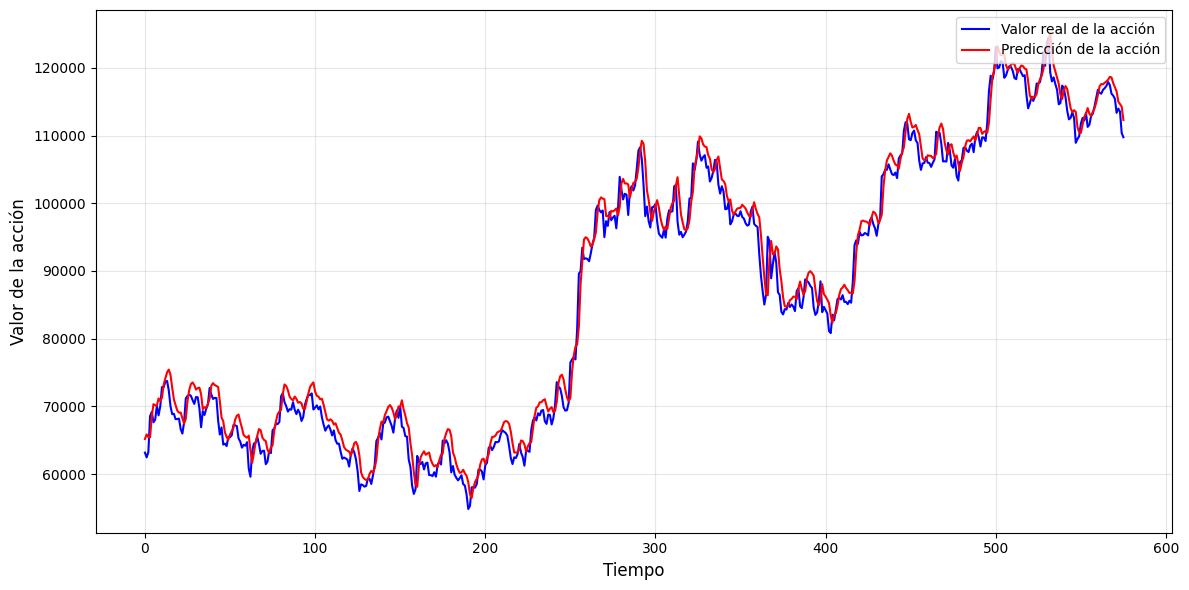

In [10]:
fechas_validacion = set_validacion.index[time_step:]
valores_reales = set_validacion.iloc[time_step:, 0].values

plt.figure(figsize=(12, 6))
plt.plot(valores_reales, label='Valor real de la acción', color='blue', linewidth=1.5)
plt.plot(prediccion, label='Predicción de la acción', color='red', linewidth=1.5)

plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('Valor de la acción', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [11]:
rentability = 1
for i in range(1,len(valores_reales)):
  if prediccion[i] > valores_reales[i-1]:
    rentability*= valores_reales[i]/valores_reales[i-1]

print((rentability-1)*100,"%")

69.82785628451754 %


In [12]:
directional_accuracy = np.mean(
    (np.sign(prediccion[1:] - prediccion[:-1]) ==
     np.sign(valores_reales[1:] - valores_reales[:-1]))
)
print("Precisión direccional:", directional_accuracy*100, "%")

Precisión direccional: 50.00529300567108 %


In [13]:
daily_return = (rentability ** (1/len(valores_reales))) - 1
print(daily_return * 100, "% por día")

0.09198935509995287 % por día


In [14]:
dias_futuros = 10

ultimo_bloque = df['High'].values[-time_step:]
ultimo_bloque_escalado = scaler.transform(ultimo_bloque.reshape(-1, 1))

predicciones_futuras = []

bloque_actual = ultimo_bloque_escalado.copy()

for i in range(dias_futuros):
    X_futuro = bloque_actual.reshape(1, time_step, 1)
    prediccion_escalada = modelo.predict(X_futuro, verbose=0)
    predicciones_futuras.append(prediccion_escalada[0, 0])
    bloque_actual = np.append(bloque_actual[1:], prediccion_escalada)

predicciones_futuras = np.array(predicciones_futuras).reshape(-1, 1)
predicciones_futuras = scaler.inverse_transform(predicciones_futuras)

from datetime import timedelta
ultima_fecha = df.index[-1]
fechas_futuras = [ultima_fecha + timedelta(days=i+1) for i in range(dias_futuros)]

print("PREDICCIONES PARA LOS PRÓXIMOS", dias_futuros, "DÍAS:")
print("="*60)
for fecha, precio in zip(fechas_futuras, predicciones_futuras):
    print(f"{fecha.strftime('%Y-%m-%d')}: ${precio[0]:,.2f}")
print("="*60)

c:\Users\jeron\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


PREDICCIONES PARA LOS PRÓXIMOS 10 DÍAS:
2025-09-28: $110,985.98
2025-09-29: $111,148.16
2025-09-30: $111,472.88
2025-10-01: $111,937.50
2025-10-02: $112,514.45
2025-10-03: $113,179.32
2025-10-04: $113,910.78
2025-10-05: $114,690.55
2025-10-06: $115,503.14
2025-10-07: $116,335.81


In [15]:
modelo.save('Modelo_V1_LSTM.h5')

modelo.save('modelo_v1_LSTM_tf.keras')